<a href="https://colab.research.google.com/github/mttcrn/AI-things/blob/main/Intrusion%20Detection%20System/IDS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Lab3: Intrusion Detection System

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import numpy as np
import matplotlib as plt
from statsmodels.distributions.empirical_distribution import ECDF

In [3]:
import tensorflow as tf
import tensorflow.keras as tfk
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras import regularizers

In [4]:
import os
folder_path = "/content/drive/MyDrive/Colab Notebooks/HPAS/eval/"

In [5]:
#input files. Do not touch.
import pandas as pd
import glob
import re

# Load training.csv
training = pd.read_csv(os.path.join(folder_path, "training.csv"))

# Load all evalN.csv files into separate dataframes named evaluationN
eval_files = glob.glob(os.path.join(folder_path, "eval*.csv"))
for f in eval_files:
    match = re.search(r'eval(\d+)\.csv', f)
    if match:
        n = match.group(1)
        df_name = f"evaluation{n}"
        globals()[df_name] = pd.read_csv(f)
        print("found evaluation dataset n°: " + df_name)

found evaluation dataset n°: evaluation5
found evaluation dataset n°: evaluation3
found evaluation dataset n°: evaluation6
found evaluation dataset n°: evaluation1
found evaluation dataset n°: evaluation8
found evaluation dataset n°: evaluation2
found evaluation dataset n°: evaluation4
found evaluation dataset n°: evaluation7


In [6]:
# Show training head
training.head()

,timestamp,arbitration_id,data_field,attack
0,1.672531e+09,002,FF6F700DEB000000,0
1,1.672531e+09,148,0D1754804100EE05,0
2,1.672531e+09,149,87013F4F4A3E0000,0
3,1.672531e+09,152,F1B400000000108C,0
4,1.672531e+09,075,0000000000000AD8,0


In [7]:
# Make a copy of training in df
df = training.copy()

In [8]:
# Remove useless columns for now
df = df.drop(columns=['attack'])

# Make a set of normal ids
training_ids = set(training['arbitration_id'].unique())

# Check for NaN values
print("NaNs in the dataset:", df.isna().sum().sum())

NaNs in the dataset: 0


In [9]:
def compute_hamming_distance(b1, b2):
    """Compute Hamming distance between two byte strings."""
    return sum(bin(x ^ y).count('1') for x, y in zip(b1, b2))

In [10]:
def hex_to_bytes(hex_str):
    """Convert 16-char hex payload to bytes object."""
    if isinstance(hex_str, str) and len(hex_str) == 16:
        return bytes.fromhex(hex_str)
    return b'\x00' * 8  # fallback for malformed data

In [11]:
def add_hamming_feature(df):
    df = df.copy()
    df['data_bytes'] = df['data_field'].apply(hex_to_bytes)
    df['hamming_dist_prev'] = 0

    for msg_id, group in df.groupby('arbitration_id'):
        group_sorted = group.sort_values('timestamp')
        indices = group_sorted.index.tolist()
        payloads = list(group_sorted['data_bytes'])

        for i in range(1, len(payloads)):
            dist = compute_hamming_distance(payloads[i-1], payloads[i])
            df.at[indices[i], 'hamming_dist_prev'] = dist

    return df.drop(columns=['data_bytes'])

In [12]:
def extract_data(df):
    """Extract byte-level and statistical features from the data_field."""
    df = df.copy()

    # Convert data_field to list of bytes
    df['data_bytes'] = df['data_field'].apply(hex_to_bytes)

    # Extract each byte into its own column
    byte_columns = pd.DataFrame(
        df['data_bytes'].apply(lambda b: list(b)).tolist(),
        columns=[f'byte_{i}' for i in range(8)]
    ).astype(np.float32)

    # Total integer value of payload
    df['payload_value'] = df['data_field'].apply(lambda x: int(x, 16) if isinstance(x, str) and len(x) == 16 else 0)
    byte_columns['payload_value'] = df['payload_value']

    return byte_columns

In [34]:
def extract_features(training):
  df = training.copy()
  # Arbitration Id in int
  df['arbitration_id_int'] = df['arbitration_id'].apply(lambda x: int(x, 16))

  # Message count per ID
  df['msg_count_id'] = df.groupby('arbitration_id')['arbitration_id'].transform('count')

  # Time since beginning
  df['time'] = df['timestamp'] - df['timestamp'].min()

  # Inter arrival time
  df['inter_arrival_time'] = df.groupby('arbitration_id')['timestamp'].diff().fillna(0)

  # Data-fields -> IT WORSEN THE PERFORMANCE
  #df_data = extract_data(df)

  # Hammming distance w.r.t. previoud message from the same ID
  df = add_hamming_feature(df)

  # Combine features into one DataFrame
  features = pd.concat([
        df['arbitration_id_int'], df['time'], df['msg_count_id'], df['hamming_dist_prev'].astype(np.float32), df['inter_arrival_time']
  ], axis=1)

  return features

In [35]:
# Scale all numeric features
scaler = MinMaxScaler()

features = extract_features(training)
scaler.fit(features)
features_scaled = pd.DataFrame(scaler.transform(features), columns=features.columns)

In [36]:
features.head()

,arbitration_id_int,time,msg_count_id,hamming_dist_prev,inter_arrival_time
0,2,0.000000,57020,0.0,0.0
1,328,0.000808,57056,0.0,0.0
2,329,0.001049,57056,0.0,0.0
3,338,0.001831,28604,0.0,0.0
4,117,0.005431,28508,0.0,0.0


In [37]:
features_scaled.head()

,arbitration_id_int,time,msg_count_id,hamming_dist_prev,inter_arrival_time
0,0.000000,0.000000,0.999369,0.0,0.0
1,0.163655,0.000001,1.000000,0.0,0.0
2,0.164157,0.000002,1.000000,0.0,0.0
3,0.168675,0.000003,0.501315,0.0,0.0
4,0.057731,0.000009,0.499632,0.0,0.0


In [43]:
# Build autoencoder
input_dim = features_scaled.shape[1]

autoencoder = tfk.models.Sequential([
    tfk.layers.Input(shape=(input_dim,)),
    tfk.layers.Dense(128, activation='relu'),
    tfk.layers.Dense(64, activation='relu'),
    tfk.layers.Dense(16, activation='relu'),  # bottleneck
    tfk.layers.Dense(64, activation='relu'),
    tfk.layers.Dense(128, activation='relu'),
    tfk.layers.Dense(input_dim, activation='sigmoid')
])

autoencoder.compile(optimizer=tfk.optimizers.Adam(learning_rate=0.001), loss='mse')

In [44]:
# Early stopping callback
early_stopping = tfk.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True
)

# Train autoencoder
history = autoencoder.fit(features_scaled, features_scaled,
                          epochs=20,
                          batch_size=256,
                          shuffle=True,
                          validation_split=0.1,
                          callbacks=[early_stopping])

Epoch 1/20
3236/3236 ━━━━━━━━━━━━━━━━━━━━ 13s 3ms/step - loss: 0.0075 - val_loss: 2.1723e-04
Epoch 2/20
3236/3236 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - loss: 1.4260e-05 - val_loss: 2.0411e-04
Epoch 3/20
3236/3236 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - loss: 9.4268e-06 - val_loss: 2.3394e-04
Epoch 4/20
3236/3236 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - loss: 8.5448e-06 - val_loss: 2.2845e-04
Epoch 5/20
3236/3236 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step - loss: 6.5544e-06 - val_loss: 1.7935e-04
Epoch 6/20
3236/3236 ━━━━━━━━━━━━━━━━━━━━ 11s 3ms/step - loss: 5.9725e-06 - val_loss: 1.6240e-04
Epoch 7/20
3236/3236 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - loss: 5.2321e-06 - val_loss: 1.6791e-04
Epoch 8/20
3236/3236 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - loss: 4.9897e-06 - val_loss: 1.5997e-04
Epoch 9/20
3236/3236 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step - loss: 5.6264e-06 - val_loss: 1.5097e-04
Epoch 10/20
3236/3236 ━━━━━━━━━━━━━━━━━━━━ 11s 3ms/step - loss: 4.7186e-06 - val_loss: 1.7964e-04
Epoch 11/20
3236/3236 ━━━━━━━━━━━━━━━

In [45]:
train_predictions = autoencoder.predict(features_scaled)
train_reconstruction_errors = np.mean(np.power(features_scaled - train_predictions, 2), axis=1)
threshold = np.percentile(train_reconstruction_errors, 99.99)  # fixed threshold found on a paper
print("Fixed threshold (99.99th percentile on training):", threshold)

28761/28761 ━━━━━━━━━━━━━━━━━━━━ 41s 1ms/step
Fixed threshold (99.99th percentile on training): 0.0007950966205275996


In [46]:
def ids(eval_df):
    # result_df needs to be the same as eval_df, with the predicted_attack column
    global scaler, autoencoder, threshold, training_ids

    # Make a copy of the input
    df = eval_df.copy()
    df = df.drop(columns=['attack'])

    # Extract and scale features
    test_features = extract_features(df)
    test = scaler.transform(test_features)

    # Making the predictions
    predictions = autoencoder.predict(test)

    # Compute reconstruction error for each test sample
    reconstruction_errors = np.mean(np.power(test - predictions, 2), axis=1)

    result_df = eval_df.copy()
    result_df['predicted_attack'] = (reconstruction_errors > threshold).astype(int)

    # All packets with newer arbitration_id are attacks
    result_df.loc[~result_df['arbitration_id'].isin(training_ids), 'predicted_attack'] = 1

    return result_df

running evaluation5
782/782 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
running evaluation3
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
running evaluation6
407/407 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
running evaluation1
407/407 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
running evaluation8
469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
running evaluation2
407/407 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
running evaluation4
126/126 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
running evaluation7
876/876 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step

evaluation5 Evaluation Metrics:
  Accuracy: 0.9310
  Precision: 0.8188
  Recall: 0.9891
  F1_score: 0.8959

evaluation3 Evaluation Metrics:
  Accuracy: 0.7886
  Precision: 0.2653
  Recall: 0.3212
  F1_score: 0.2906

evaluation6 Evaluation Metrics:
  Accuracy: 0.9263
  Precision: 0.2676
  Recall: 1.0000
  F1_score: 0.4222

evaluation1 Evaluation Metrics:
  Accuracy: 0.9438
  Precision: 0.8621
  Recall: 1.0000
  F1_score: 0.9259

evaluation8 Evaluation Metrics:
  Accuracy: 0.8871
  Precision: 0.0276
  Recall

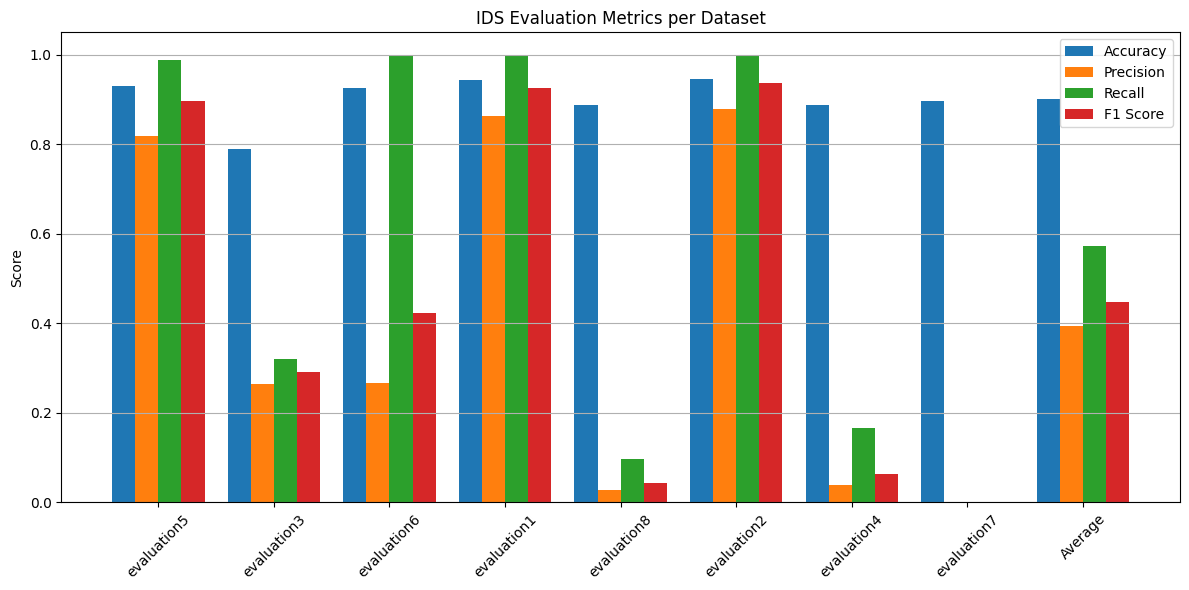


Total Elapsed Time: 14.22 seconds


In [47]:
#evaluation sequence. Do not touch.
import time  # Add this
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

start_time = time.time()  # Start timing

evaluation_metrics = {}
all_globals = list(globals().items())

# Loop through evaluation dataframes
for name, df in all_globals:
    if name.startswith("evaluation") and isinstance(df, pd.DataFrame):
        # Run IDS
        print("running " + name)
        detected_df = ids(df)

        # Compare predictions to ground truth
        y_true = detected_df['attack']
        y_pred = detected_df['predicted_attack']

        # Compute metrics
        metrics = {
            'accuracy': accuracy_score(y_true, y_pred),
            'precision': precision_score(y_true, y_pred, zero_division=0),
            'recall': recall_score(y_true, y_pred, zero_division=0),
            'f1_score': f1_score(y_true, y_pred, zero_division=0),
        }

        evaluation_metrics[name] = metrics

# Compute average metrics
avg_metrics = {
    metric: np.mean([metrics[metric] for metrics in evaluation_metrics.values()])
    for metric in ['accuracy', 'precision', 'recall', 'f1_score']
}
evaluation_metrics['Average'] = avg_metrics

# Display metrics
for name, metrics in evaluation_metrics.items():
    print(f"\n{name} Evaluation Metrics:")
    for metric, value in metrics.items():
        print(f"  {metric.capitalize()}: {value:.4f}")

# Plotting
labels = list(evaluation_metrics.keys())
x = np.arange(len(labels))
width = 0.2

# Prepare metric lists
accuracy = [evaluation_metrics[label]['accuracy'] for label in labels]
precision = [evaluation_metrics[label]['precision'] for label in labels]
recall = [evaluation_metrics[label]['recall'] for label in labels]
f1 = [evaluation_metrics[label]['f1_score'] for label in labels]

# Create the bar chart
plt.figure(figsize=(12, 6))
plt.bar(x - 1.5*width, accuracy, width, label='Accuracy')
plt.bar(x - 0.5*width, precision, width, label='Precision')
plt.bar(x + 0.5*width, recall, width, label='Recall')
plt.bar(x + 1.5*width, f1, width, label='F1 Score')

plt.xticks(x, labels, rotation=45)
plt.ylabel('Score')
plt.title('IDS Evaluation Metrics per Dataset')
plt.ylim(0, 1.05)
plt.legend()
plt.tight_layout()
plt.grid(axis='y')
plt.show()

# End timing
end_time = time.time()
elapsed_time = end_time - start_time
print(f"\nTotal Elapsed Time: {elapsed_time:.2f} seconds")


### Considerations

*   Evaluation 1 & 2 are well described by the set of features: `arbitration_id_int`, `msg_count_id`, `time_delta`

* Evaluation 1, 2, 5 & 6 (not for precision) are well described by the set of features: `arbitration_id_int`, `msg_count_id`, `time_delta`, `hamming_dist_prev` -> F1 above 0.4

* Adding the fact that a newer ID is an attack should improve eval 2 & 5. -> F1 = 0.43

* Evaluation 2, 5 & 6 are well described by the set of feature: `arbitration_id_int`, `msg_count_id`, `time_delta`, `hamming_dist_prev`, `inter-arrival-time` -> F1 = 0.4479